In [34]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, lil_matrix, kron
from scipy.linalg import sqrtm
from scipy.special import factorial, kv
from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

In [90]:
def Sph_vec_coordinates(m, n):
    theta0, phi0 = np.linspace(0, np.pi, m), np.linspace(0, 2*np.pi, n, endpoint=False)
    theta, phi = np.meshgrid(theta0, phi0)
    theta, phi = theta.flatten(), phi.flatten()
    sph_vec = np.zeros((len(theta), 2))
    sph_vec[:,0], sph_vec[:,1] = theta, phi
    return sph_vec

def Sph_cart_coordinates(sph_vec):
    theta, phi = sph_vec[:,0], sph_vec[:,1]
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return x, y, z

def geo_dist(x1, y1, z1, x2, y2, z2):
    geo_d = np.arccos(np.round(x1*x2 + y1*y2 +z1*z2, 15))
    return geo_d

def Sph_cov1(x, y, z, n, m, phi):
    cov = np.zeros((m, n*m))
    for i in range(m):
        cov[i, :] = np.exp(-geo_dist(x[i], y[i], z[i], x, y, z)/phi)
    return cov

def Sph_cov2(x, y, z, n, m, alpha, beta, phi):
    cov = np.zeros((m, n*m))
    for i in range(m):
        cov[i, :] = (1 + (geo_dist(x[i], y[i], z[i], x, y, z)/phi)**(alpha))**(-beta/alpha)
    return cov

def Sph_cov3(x, y, z, n, m, phi, v=0.5):
    cov = np.zeros((m, n*m))
    for i in range(m):
        cov[i, :] = (2**(1-v)/np.sqrt(np.pi))*((geo_dist(x[i], y[i], z[i], x, y, z)/phi)**v)*kv(v, geo_dist(x[i], y[i], z[i], x, y, z)/phi)
        cov[np.isnan(cov)] = 1
    return cov

def fourier_mat(n):
    F = np.zeros((n, n), dtype=np.complex)
    for i in range(n):
        for j in range(n):
            F[i, j] = np.exp(-2*np.pi*1j/n)**(i*j)
    return F

def diagonal_lamda(lamda, n, m):
    diag_lamda = lil_matrix((n*m, n*m), dtype=np.complex)
    for i in range(n):
        diag_lamda[(i*m):(i+1)*m, (i*m):(i+1)*m] = sqrtm(lamda[:,(i*m):(i+1)*m])
    return diag_lamda

def Sph_GRF(m, n, phi, model, alpha = 0, beta = 0, v = 0):
    sph_vec = Sph_vec_coordinates(m, n)
    x, y, z = Sph_cart_coordinates(sph_vec=sph_vec)
    if model == "exp":
        cov = Sph_cov1(x, y, z, n, m, phi)
    elif model == "Cauchy":
        cov = Sph_cov2(x, y, z, n, m, alpha, beta, phi)
    elif model == "Bessel":
        cov = Sph_cov3(x, y, z, n, m, phi, v)
    F = fourier_mat(n)
    F_I = kron(csr_matrix(F), csr_matrix(np.diag(np.ones(m))))
    lamda = csr_matrix(cov).dot(F_I).todense()
    diag_lamda = diagonal_lamda(lamda, n, m)
    Z = np.random.normal(0,1,n*m) + 1j*np.random.normal(0,1,n*m)
    diag_lamda_Z = csr_matrix(diag_lamda).dot(csr_matrix(Z).T)
    X = np.real(F_I.dot(diag_lamda_Z).todense())/np.sqrt(n)
    Y1 = np.array(X).reshape(m*n)
    return Y1, sph_vec

In [91]:
import numpy as np
import matplotlib.pyplot as plt


## I keep this function here only for sampling from OOV. To be depreciated.
def Sph_coordinates_new(n):
    #theta = np.arccos(np.linspace(-1, 1, n+1))
    theta = (np.linspace(0, np.pi, n))
    phi = np.linspace(0, 2*np.pi, n,endpoint=False)
    theta,phi = np.meshgrid(theta,phi)
    theta,phi = theta.flatten(),phi.flatten()
    
    x = np.sin(theta)*np.cos(phi)
    y = np.sin(theta)*np.sin(phi)
    z = np.cos(theta)
    return x, y, z, theta, phi

## theta,phi\in [0,pi]*[0,2pi)

## YZ: all the sampling functions should take argument sph_vec as a vector of polar coordiates 
## (instead of theta,phi as two separate vectors of the same size), 
## as the following function
def Sph_coordinates_vec(n):
    #theta = np.arccos(np.linspace(-1, 1, n+1))
    theta = (np.linspace(0, np.pi, n))
    phi = np.linspace(0, 2*np.pi, n,endpoint=False)
    theta,phi = np.meshgrid(theta,phi)
    theta,phi = theta.flatten(),phi.flatten()

    sph_vec = np.zeros((n,2))
    sph_vec[:,0] = theta
    sph_vec[:,1] = phi
    
    return sph_vec

## translate bewteen cartesian and spherical (polar) coordinates.
def cart2sph_vec(cart_vec):
    not_a_sequence = False
    if cart_vec.shape == (2,): 
        not_a_sequence = True
        cart_vec = cart_vec.reshape(1,2)
        
    n = cart_vec[:,0].size
    dxy = np.sqrt(cart_vec[:,0]**2 + cart_vec[:,1]**2)
    
    phi_vec = np.zeros((n,2))
    phi_vec[:,1] = np.arctan2(cart_vec[:,1], cart_vec[:,0])
    phi_vec[:,0] = np.pi/2 - np.arctan2(cart_vec[:,2], dxy)

    if not_a_sequence == True: return phi_vec[0,:]
    return phi_vec
   
def sph2cart_vec(sph_vec):
    not_a_sequence = False
    if sph_vec.shape == (2,): 
        not_a_sequence = True
        sph_vec = sph_vec.reshape(1,2)
        
    n = sph_vec[:,0].size
    cart_vec = np.zeros((n,3))
    cart_vec[:,2] = np.cos(sph_vec[:,0])
    rsintheta = np.sin(sph_vec[:,0])
    cart_vec[:,0] = rsintheta * np.cos(sph_vec[:,1])
    cart_vec[:,1] = rsintheta * np.sin(sph_vec[:,1])

    if not_a_sequence == True: return cart_vec[0,:]
    return cart_vec
    
def geo_dist_vec(sph_v1,sph_v2):
    return np.arccos(np.cos(sph_v1[:,0])*np.cos(sph_v2[:,0])+np.sin(sph_v1[:,0])*np.sin(sph_v2[:,0])*np.cos(sph_v1[:,1]-sph_v2[:,0]))


from scipy.interpolate import griddata
from scipy.spatial.transform import Rotation

#new_NP_sph in spherical coordinate
def rotate_NP(sph_v,new_NP_sph):
    if new_NP_sph[0] == 0: return sph_v
    
    new_NP_cart = sph2cart_vec(new_NP_sph)
    angle = np.arccos(np.dot(new_NP_cart,[0,0,1]))
    axis = np.cross(new_NP_cart,[0,0,1])/np.sin(angle)
    r = Rotation.from_rotvec(angle * axis)

    cart_v = sph2cart_vec(sph_v)                 
    sph_v_rotated = cart2sph_vec(r.apply(cart_v))
    return sph_v_rotated

def rotate_NP_inv(sph_v,new_NP_sph):
    if new_NP_sph[0] == 0: return sph_v
    
    new_NP_cart = sph2cart_vec(new_NP_sph)
    angle = np.arccos(np.dot(new_NP_cart,[0,0,1]))
    axis = np.cross(new_NP_cart,[0,0,1])/np.sin(angle)
    r = Rotation.from_rotvec(angle * axis)
    r = r.inv()

    cart_v = sph2cart_vec(sph_v)                 
    sph_v_rotated = cart2sph_vec(r.apply(cart_v))
    return sph_v_rotated


def polar2hemisphere(nn,X,sph_v, method = 'cubic'):
    
    NP = np.array([0,0]).reshape(1,2)
    xi, yi = np.meshgrid(np.linspace(-1,1, nn),np.linspace(-1,1, nn))
    ind_hemi = np.asarray(geo_dist_vec(sph_v,NP) <np.pi/2).nonzero()[0]
    cart_v = sph2cart_vec(sph_v[ind_hemi,:])
    ## method = 'cubic', 'nearest', 'linear'
    zi = griddata(cart_v[:,[0,1]], X[ind_hemi], (xi, yi), method='cubic')
    return xi,yi,zi

def hemisphere_select(sph_v, X):    
    NP = np.array([0,0]).reshape(1,2)
    ind_hemi = np.where(geo_dist_vec(sph_v,NP) <np.pi/2)[0]
    return sph_v[ind_hemi,:],X[ind_hemi]


def great_circle(n,NP):
    sph_v = np.zeros((n+1,2))
    sph_v[:,0] = np.pi/2
    sph_v[:,1] = np.linspace(0,np.pi*2,n+1,endpoint = True)
    return rotate_NP_inv(sph_v,NP)



def great_circle_in_hemi(n,NP):
    sph_v = great_circle(n,NP)
    NP0 = np.array([0,0]).reshape(1,2)
    ind_hemi = np.where(geo_dist_vec(sph_v,NP0) <np.pi/2)[0]
    sph_v = sph_v[ind_hemi,:]
    cart_v = sph2cart_vec(sph_v)
    diff_v = np.diff(cart_v[:,0])**2+np.diff(cart_v[:,1])**2
    #find where is the largest gap (where the great_circle has a "gap" in the hemisphere)

    max_ind = np.argmax(diff_v)
    diff_value1 = diff_v[max_ind]
    ll = sph_v[:,0].size
    diff_value2 = (cart_v[0,0]-cart_v[ll-1,0])** 2 + (cart_v[0,1]-cart_v[ll-1,1])**2

    if diff_value1 > diff_value2: 
        sph_new = np.concatenate((sph_v[(max_ind+1):,:],sph_v[0:(max_ind-1),:]))
    else: sph_new = sph_v

    return sph_new
    

In [92]:
m = 300
n = 150
nn = 300

sph_vec = Sph_vec_coordinates(m, n)
x, y, z = Sph_cart_coordinates(sph_vec)

Y1 = Sph_GRF(m=m, n=n, phi=0.5, model = "exp")[0]
Y2 = Sph_GRF(m=m, n=n, phi=1, model = "Cauchy", alpha = 0.5, beta = 2)[0]
Y3 = Sph_GRF(m=m, n=n, phi=0.7, model = "Bessel", v = 0.25)[0]

xi1, yi1, zi1 = polar2hemisphere(nn, Y1, sph_vec)
xi2, yi2, zi2 = polar2hemisphere(nn, Y2, sph_vec)
xi3, yi3, zi3 = polar2hemisphere(nn, Y3, sph_vec)

TT = np.linspace(0,2*np.pi,n)
XX,YY = np.cos(TT),np.sin(TT)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning:

invalid value encountered in multiply



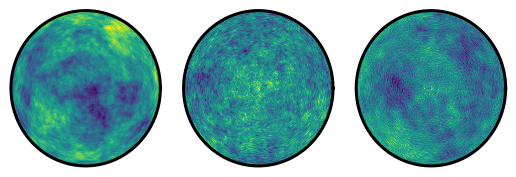

In [93]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
#plt.rc('font', size=15)
plt.subplots_adjust(wspace = 0.1)

axs[0].pcolormesh(xi1,yi1,zi1,cmap = "viridis",rasterized=True)
axs[0].plot(XX,YY,color = "black", linewidth = 3)
axs[0].set_xlim([-1.05, 1.05])
axs[0].set_ylim([-1.05, 1.05])
axs[0].axis('off')

axs[1].pcolormesh(xi2,yi2,zi2,cmap = "viridis",rasterized=True)
axs[1].plot(XX,YY,color = "black", linewidth = 3)
axs[1].set_xlim([-1.05, 1.05])
axs[1].set_ylim([-1.05, 1.05])
axs[1].axis('off')

im = axs[2].pcolormesh(xi3,yi3,zi3,cmap = "viridis",rasterized=True)
axs[2].plot(XX,YY,color = "black", linewidth = 3)
axs[2].set_xlim([-1.05, 1.05])
axs[2].set_ylim([-1.05, 1.05])
axs[2].axis('off')

#cax = fig.add_axes([axs[2].get_position().x1+0.01,axs[2].get_position().y0,0.02,axs[2].get_position().height])
#plt.colorbar(im, cax=cax) 

plt.savefig('SphericalGRF.pdf', bbox_inches = 'tight')

plt.show()